### LangGraph 多智能体协作中文指南

在单个领域中，通常一个智能体能够有效地使用一些工具，但即使是使用强大的模型（例如 GPT-4），它在使用大量工具时效果可能会有所降低。

一种解决复杂任务的方法是采用“分而治之”的方式：为每个任务或领域创建一个专门的智能体，并将任务路由到正确的“专家”。

本指南灵感来自 Wu 等人的论文《AutoGen: 通过多智能体对话实现下一代 LLM 应用》 展示了使用 LangGraph 进行多智能体协作的一种方法。

### 工作流程概述

工作流程清晰地展示了多智能体协作的核心步骤，便于理解 LangGraph 的实现方法。

1. **定义辅助函数：create_agent**：为每个任务创建独立的智能体，例如研究智能体、图表生成器智能体等。每个智能体使用独立的语言模型和工具。
2. **定义工具**：为每个智能体提供专用的工具，例如 Tavily 搜索工具和 Python REPL 工具，用于执行特定任务。
3. **定义辅助函数：agent_node**：将每个智能体与对应任务进行关联，定义图中的智能体节点，使其能够处理特定任务。
4. **定义研究智能体及节点: Researcher**: 研究智能体使用 Tavily 搜索工具，回应用户提问。
5. **定义图表生成器智能体及节点: Chart_Generator**: 根据提供的数据，在沙盒环境执行 Python 代码生成图表。
6. **导入预构建的工具节点: ToolNode**: 将2中定义的 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。
7. **建立智能体节点间通信: AgentState**：通过 LangGraph 实现智能体间通信，智能体能够共享状态并相互协作完成复杂任务。
8. **定义工作流（状态图)**：创建状态图以管理多智能体协作的流程，包含任务路由和边逻辑，确保正确的智能体按顺序执行。
9. **执行工作流**：根据状态图执行多智能体任务，通过工具调用和智能体协作，完成目标任务并生成最终输出。

最终的工作流执行时应像下图所示：

![simple_multi_agent_diagram](./images/simple_multi_agent_diagram.png)


### **说明**

经过多次测试，多智能体在 gpt-4o 上成功运行。见指南最后的 GPT-4o 模型生成结果 章节。

当切换为 gpt-4o-mini 时，`Research` 能够生成对应的 Python 代码，但会一定概率路由 `Chart_Generator` 失败，无法调用 Python REPL 工具生成图表。

In [1]:
%%capture --no-stderr
%pip install langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"



### 1. 辅助函数：创建智能体

以下助手函数将帮助我们创建智能体。这些智能体将成为图中的节点。

#### 注释说明：
- 该函数 `create_agent` 用于创建一个智能体，通过为该智能体提供系统消息和可以使用的工具来指定其行为。
- `ChatPromptTemplate.from_messages` 是用于构建该智能体的对话提示模板，系统消息告诉智能体它是如何与其他智能体协作的。
- 提示模板通过 `partial` 函数插入了系统消息和工具名称，使得智能体能够根据提供的工具执行任务。
- 最终，智能体被绑定到所提供的 LLM（大型语言模型）和工具列表中，构成一个完整的智能体逻辑。


In [3]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



#### `partial` 是什么

在 Python 中，`partial` 方法是 `functools` 模块中的一个功能，它用于创建一个**新的函数**，这个函数是基于原函数的**部分参数已经固定**的版本。这在需要重复调用同一函数，并且传递相同的某些参数时非常有用。

####  `partial` 的基本理解

通过 `partial`，我们可以预先为函数的某些参数赋值，生成一个新的函数，这个新函数已经预先固定了部分参数，只需要再传递剩下的参数即可。

#### `prompt.partial` 解析

这里的 `partial` 用于创建一个新的提示模板对象，并为 `system_message` 和 `tool_names` 这两个参数提供了值。这相当于对提示模板的“定制”，预先指定了这些参数的值。

**`partial` 的具体作用：**

1. 调用 `prompt.partial(system_message=system_message)`，预先为 `system_message` 参数赋值，生成一个新的提示模板，固定了系统消息的内容。
2. 调用 `prompt.partial(tool_names=", ".join([tool.name for tool in tools]))`，为 `tool_names` 参数赋值，将所有工具的名称合并成一个字符串，并固定在新的模板中。

通过这两步 `partial` 调用，`prompt` 对象中已经预先填入了 `system_message` 和 `tool_names` 这两个参数，简化了后续的调用过程。

--------------------


### 2. 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

-----------

### 3. 辅助函数：智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它分别定义2个智能体节点：
- Researcher
- Chart_Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"Chart_Generator"`，并与各自的智能体绑定。

In [5]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

#### 关于 `AIMessage` 构造

`AIMessage` 是 LangChain 中用于表示 AI 模型回复的类，它封装了 AI 生成的文本或内容。为了让 Python 初学者更好地理解，我们可以从以下几个方面详细说明 `AIMessage` 的构造方法及其相关概念。

##### `AIMessage` 构造方法简介

在代码中，`AIMessage(**result.dict(exclude={"type", "name"}), name=name)` 这段代码使用了 `AIMessage` 的构造方法。`AIMessage` 的目的是将 AI 生成的消息封装起来，方便后续处理和传递。这里的构造方法通过传递字典参数创建 `AIMessage` 对象。

##### `AIMessage` 类的常见构造参数：
- **content**: 这是消息的主要部分，通常是 AI 模型生成的文本内容。例如，一个简单的对话模型可能会生成一个包含回答问题的字符串。
- **name**: 可选参数，用于标识发送消息的 AI 模型或智能体的名称。在你的代码中，`name=name` 表示为智能体分配一个名称（如 `"Researcher"` 或 `"Chart_Generator"`），以便在不同智能体之间进行区分。
- **additional_metadata**: 有时候，消息不仅仅包含文本内容，还可能附加其他元数据，如调用的工具、时间戳等。

##### 深入理解构造方法中的步骤：

1. **`result.dict()`**: 
   这一部分将 `result` 对象转换为字典。字典是一种键值对的结构，便于存储和管理数据。Python 中的 `dict()` 方法会把 `result` 对象的所有属性转换成字典的形式，方便在构造 `AIMessage` 时传递这些数据。

2. **`exclude={"type", "name"}`**:
   在构造 `AIMessage` 时，使用了 `exclude` 参数来排除某些不必要的字段。`type` 和 `name` 这两个字段不会被传递给 `AIMessage`，这是因为它们可能不是 AI 消息本身的必要部分或已经在其他地方定义过。

3. **`name=name`**:
   这里的 `name` 参数表示智能体的名称，它是在 `agent_node` 函数中作为参数传递的。在构造 `AIMessage` 时，通过这个参数来标识消息的来源智能体是谁，比如 `"Researcher"` 或 `"Chart_Generator"`。

--------------

### 4. 定义 研究智能体及其节点


In [6]:
# 为 Agent 配置各自的大模型
research_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
table_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [7]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="Before using the search engine, carefully think through and clarify the query. "
    "Then, conduct a single search that addresses all aspects of the query in one go.",  # 系统消息，指导智能体如何使用搜索工具
)

In [8]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

这里的 `functools.partial` 创建了一个新的函数 `research_node`，该函数基于原始的 `agent_node` 函数，且已经为 `agent_node` 的部分参数（`agent` 和 `name`）预先设置了值。新的 `research_node` 函数只需要接收剩余的参数就可以正常运行。


**`partial` 的具体作用：**

1. **原始函数 `agent_node`**：
   ```python
   def agent_node(state, agent, name):
       # 函数体...
   ```
   - `agent_node` 是一个接受 `state`, `agent`, 和 `name` 三个参数的函数。

2. **使用 `functools.partial`**：
   ```python
   research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
   ```
   - 通过 `functools.partial`，我们创建了一个新的函数 `research_node`，它仍然是 `agent_node`，但 `agent` 参数和 `name` 参数已经被预先固定：
     - `agent=research_agent`
     - `name="Researcher"`
   - 也就是说，调用 `research_node` 时，只需要传递 `state` 参数，因为 `agent` 和 `name` 已经有默认值了。

**举个例子**

假设有一个函数 `agent_node`，你经常需要调用它并传递相同的 `agent` 和 `name`，那么每次调用时重复写这些参数会很冗余。使用 `partial` 可以避免这种重复。

```python
# 原始函数定义
def agent_node(state, agent, name):
    print(f"State: {state}, Agent: {agent}, Name: {name}")

# 预先设置 agent 和 name 参数
research_node = functools.partial(agent_node, agent="research_agent_value", name="Researcher")

# 调用时只需要传递剩下的参数
research_node(state="current_state")
# 输出: State: current_state, Agent: research_agent_value, Name: Researcher
```

#### `functools.partial` 的优势

1. **减少重复代码**：在你需要多次调用同一个函数并且某些参数不变时，`partial` 可以避免每次都传递相同的参数。
   
2. **简化函数调用**：在需要频繁使用相同参数时，`partial` 提供了更简洁的写法，使代码更易于维护。

#### 总结

在这段代码中，`functools.partial` 的用法预先为 `agent_node` 函数的部分参数（`agent` 和 `name`）赋值，创建了一个新函数 `research_node`。调用 `research_node` 时，只需要传递剩下的参数（`state`），从而简化了函数调用的流程。

------------------

### 5. 定义 表格生成器智能体及其节点

In [9]:
table_agent = create_agent(
    table_llm,  # 使用 table_llm 作为表格生成器智能体的语言模型
    [python_repl],  # 表格生成器智能体使用 Python REPL 工具
    system_message="Create clear and user-friendly tables based on the provided data.",  # 系统消息，指导智能体如何生成表格
)

In [10]:
# 使用 functools.partial 创建表格生成器智能体的节点，指定该节点的名称为 "Table_Generator"
table_node = functools.partial(agent_node, agent=table_agent, name="Table_Generator")


### 6. 导入预构建的工具节点

我们现在导入预构建的工具节点 `ToolNode` （运行上一个AIMessage中调用工具的节点。）。将 Tavily 搜索工具和 Python REPL 工具作为一个工具节点，这样可以方便地在工作流中使用这些工具。

### 什么是 ToolNode？

**ToolNode** 是 LangChain 的一个预构建节点，它能够从图状态（`graph state`）中提取消息并调用指定的工具，最后将工具调用的结果反馈回图的状态中。ToolNode 非常适合与 LangGraph 中的 ReAct agent 协同工作，但也可以与任何 `StateGraph` 配合使用，只要状态中有 `messages` 键和合适的消息处理方式。

#### ToolNode 的特点
1. **工具调用**：ToolNode 可以根据状态中的消息自动调用指定的工具，并返回工具的执行结果。
2. **兼容性**：可以与任意支持工具调用的 LangChain 模型配合使用。
3. **并行工具调用**：支持同时调用多个工具，并处理工具返回的多个结果。
4. **错误处理**：ToolNode 默认启用了错误处理，可以处理工具在执行过程中的异常情况。

#### 与对话模型结合使用

在使用像 Anthropic 这样的对话模型时，模型可以自动生成带有 `tool_calls` 的 `AIMessage`，这样我们可以直接将模型生成的消息传给 ToolNode 来执行工具调用：

```python
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import ToolNode

model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})
# 返回: {'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='toolu_01LFvAVT3xJMeZS6kbWwBGZK')]}
```

#### ToolNode 与 ReAct Agent 结合

ReAct Agent 是 LangGraph 中的一种智能体，它会反复调用工具，直到收集到足够的信息来解决问题。以下是 ReAct Agent 的基本工作流，它通过工具节点来完成工具调用：

```python
from typing import Literal
from langgraph.graph import StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

# 创建状态图
workflow = StateGraph(MessagesState)

# 定义两个节点：一个用于调用模型，一个用于调用工具
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")  # 从 agent 节点开始
workflow.add_conditional_edges("agent", should_continue)  # 根据条件判断是否继续调用工具
workflow.add_edge("tools", "agent")  # 工具调用完成后，返回 agent 节点

app = workflow.compile()  # 编译状态图
```

#### 错误处理

ToolNode 默认启用了错误处理，可以处理工具执行中的异常情况。如果想禁用错误处理，可以设置 `handle_tool_errors=False`。

#### 总结

**ToolNode** 是一个非常强大的组件，它能够自动调用工具并将结果反馈回工作流。它可以处理单个或多个工具调用，并与 LangChain 模型紧密结合，使得在复杂的多步骤任务中能够更高效地调用外部 API 或工具。

In [11]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

------------------------


### 7. 建立智能体节点间通信 AgentState

定义智能体节点和工具节点后，接下来需要在 Graph 中使它们互相通信。

因此，我们需要定义节点间的消息传递数据结构：AgentState

我们使用一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [12]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


### 8. 定义工作流（状态图）

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`Chart_Generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

#### Graph 对象关键方法 API

- **add_conditional_edges**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#stategraph
- **get_graph**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#langgraph.graph.graph.CompiledGraph.get_graph


In [13]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Table_Generator", table_node)
workflow.add_node("call_tool", tool_node)


#### 定义路由函数

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [14]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


#### 定义条件边逻辑

In [15]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Table_Generator",  # 如果 router 返回 "continue"，则传递到 Chart_Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Table_Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Table_Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Table_Generator": "Table_Generator",  # 如果 sender 是 Chart_Generator，则返回给 Chart_Generator
    },
)


In [16]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

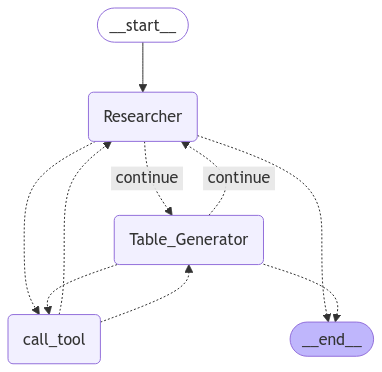

In [17]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")


### 9. 执行工作流

接下来我们将执行多智能体构建的工作流，最终生成一些统计图表。

================================ Human Message =================================

Please obtain the 10 most mainstream programming languages currently and compare these 10 programming languages from multiple perspectives. And then use Python programming: write code in Python to process the obtained data and use Python's visualization libraries to create tables.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\2335017940.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_m4P4WO6BaawdLwugxpHSpcnP)
 Call ID: call_m4P4WO6BaawdLwugxpHSpcnP
  Args:
    query: most popular programming languages 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://technostacks.com/blog/most-popular-programming-languages/", "content": "Here are the most popular programming languages of 2023 as per GitHub. Python, Java, C++ and Go programming are the top on the list. We have researched on a diverse range of development forums, discussed with programming specialists, and reviewed Github communities to explore this list."}, {"url": "https://www.statista.com/statistics/869092/worldwide-software-developer-survey-languages-used/", "content": "The most popular programming language used in the past 12 months by software developers worldwide is JavaScript as o

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\2335017940.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


================================== Ai Message ==================================
Name: Researcher

Based on the search results, here are the ten most popular programming languages in 2023:

1. **JavaScript**
2. **Python**
3. **Java**
4. **C++**
5. **Go**
6. **PHP**
7. **TypeScript**
8. **C#**
9. **Ruby**
10. **Swift**

### Comparison of the Programming Languages

#### 1. **Popularity**
   - **JavaScript**: Most widely used for web development.
   - **Python**: Gaining popularity for data science, machine learning, and web development.
   - **Java**: Long-standing popularity in enterprise applications.
   - **C++**: Used in system/software development, game development.
   - **Go**: Increasingly popular for cloud services and microservices.
   - **PHP**: Widely used for server-side web development.
   - **TypeScript**: Gaining traction due to its type safety on top of JavaScript.
   - **C#**: Common in game development and enterprise applications.
   - **Ruby**: Known for web developmen

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\2335017940.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: Table_Generator
Tool Calls:
  python_repl (call_4XaOOe25h7KEfIkg6q3JRES4)
 Call ID: call_4XaOOe25h7KEfIkg6q3JRES4
  Args:
    code: import pandas as pd
import matplotlib.pyplot as plt

# Data for programming languages
data = {
    'Language': ['JavaScript', 'Python', 'Java', 'C++', 'Go', 'PHP', 'TypeScript', 'C#', 'Ruby', 'Swift'],
    'Popularity': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],  # Hypothetical values
    'Ease of Learning': [4, 9, 6, 5, 6, 7, 5, 6, 8, 7],  # Scale 1-10
    'Performance': [7, 5, 6, 9, 8, 4, 5, 6, 4, 5],  # Scale 1-10
    'Community Support': [9, 9, 8, 7, 6, 5, 7, 6, 5, 4]  # Scale 1-10
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(df['Language'], df['Popularity'], color='skyblue')
plt.xlabel('Popularity Score')
plt.title('Popularity of Programming Languages in 2023')
plt.show()


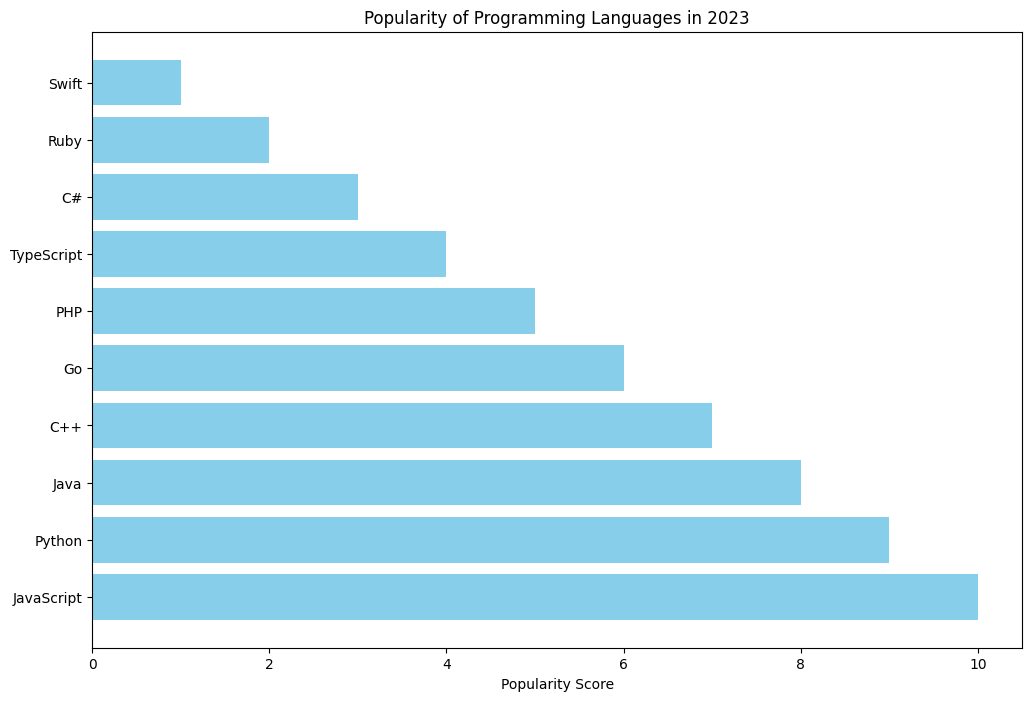

================================= Tool Message =================================
Name: python_repl

Successfully executed:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Data for programming languages
data = {
    'Language': ['JavaScript', 'Python', 'Java', 'C++', 'Go', 'PHP', 'TypeScript', 'C#', 'Ruby', 'Swift'],
    'Popularity': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],  # Hypothetical values
    'Ease of Learning': [4, 9, 6, 5, 6, 7, 5, 6, 8, 7],  # Scale 1-10
    'Performance': [7, 5, 6, 9, 8, 4, 5, 6, 4, 5],  # Scale 1-10
    'Community Support': [9, 9, 8, 7, 6, 5, 7, 6, 5, 4]  # Scale 1-10
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(df['Language'], df['Popularity'], color='skyblue')
plt.xlabel('Popularity Score')
plt.title('Popularity of Programming Languages in 2023')
plt.show()
```
Stdout:      Language  Popularity  Ease of Learning  Performance  Community Support
0  JavaScript

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12464\2335017940.py:15: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [18]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Please obtain the 10 most mainstream programming languages currently and compare these 10 programming languages from multiple perspectives. "
                "And then use Python programming: write code in Python to process the obtained data and use Python's visualization libraries to create tables."
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


### 手动复现 `python_repl` 工具执行的 Python 代码

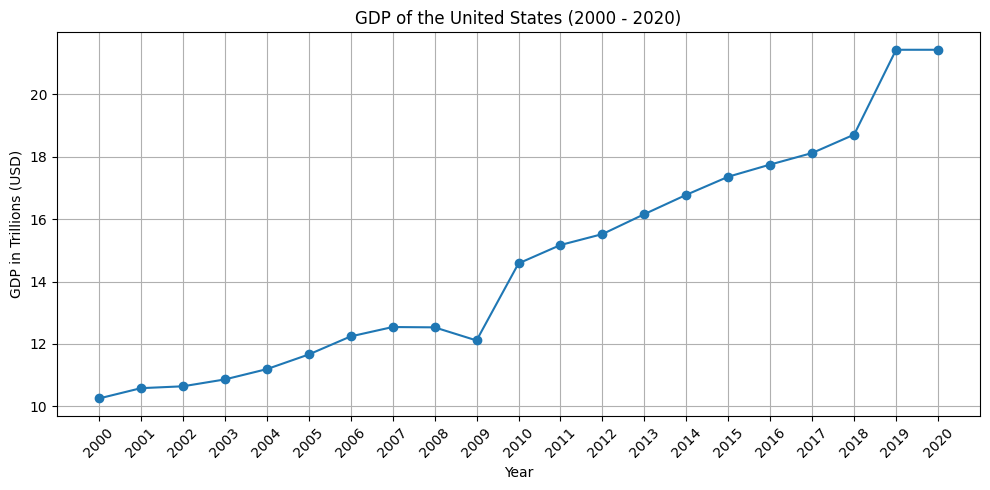

In [19]:
import matplotlib.pyplot as plt

# Years and corresponding GDP values
years = list(range(2000, 2021))
gdp_values = [
    10.25, 10.58, 10.64, 10.86, 11.19, 
    11.66, 12.24, 12.54, 12.53, 12.11, 
    14.58, 15.17, 15.52, 16.16, 16.78, 
    17.36, 17.75, 18.12, 18.71, 21.43, 
    21.43
]

# Plotting the GDP data
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_values, marker='o')
plt.title('GDP of the United States (2000 - 2020)')
plt.xlabel('Year')
plt.ylabel('GDP in Trillions (USD)')
plt.xticks(years, rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `Chart_Generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。
3. [**可选**]优化研究智能体 `Researcher` 提示词和路由函数 `route` 跳转逻辑，提升图表生成的成功率。